In [1]:
import sys

sys.path.insert(0, '/ut3/jerome/github/research/project/TOI-6715')

from toi6715 import load_plot_params

plot_params = load_plot_params()

In [2]:
from toi6715 import get_nexsci_data

table_name = 'pscomppars'
df_nexsci = get_nexsci_data(table_name)

Column definitions:  https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html
Loaded:  /ut3/jerome/github/research/project/TOI-6715/data/nexsci_pscomppars.csv


/ut3/jerome/github/research/project/TOI-6715/toi6715.py:312: DtypeWarning: Columns (5,6,127,130,350,353,368,396,399,405,408) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nexsci = pd.read_csv(fp)


In [3]:
# get values from default references
if table_name=="ps":
    idx = df_nexsci['default_flag'] == 1
    all_hostnames = df_nexsci[idx].hostname.unique()
    
    #TOI-1136
    idx = df_nexsci[df_nexsci.hostname=="TOI-1136"][df_nexsci[df_nexsci.hostname=="TOI-1136"].pl_refname.str.contains("Dai")].index
    df_nexsci.loc[idx,'default_flag']=1
else:
    all_hostnames = df_nexsci.hostname.unique()
len(all_hostnames)

3237

In [4]:
import astropy.units as u

# get only transiting planets
df_nexsci['pl_rade'] = df_nexsci['pl_radj']*u.Rjup.to(u.Rearth)

# filter data
idx = (df_nexsci.pl_orbper>0) & \
        (df_nexsci.pl_rade>0) & \
        (df_nexsci.st_mass>0) & \
        (df_nexsci.discoverymethod.isin(['Transit','Radial Velocity'])) #& \
        # (df_nexsci['default_flag'] == 1)
df = df_nexsci[idx]
df.shape

(4279, 684)

In [5]:
import pandas as pd

df_hosts = pd.read_excel("/ut3/jerome/github/research/project/TOI-6715/data/young_validated_planets_TOIs.xlsx", 
                         sheet_name='validated_hosts', 
                         skiprows=[1]).dropna(subset=['Host'])
df_hosts = df_hosts[df_hosts.distance<1000].reset_index(drop=True)
df_hosts.shape

(70, 33)

In [6]:
df_hosts['hostname'] = df_hosts.Host.apply(lambda x: x.lower().replace(' ', ''))
young_hostnames = df_hosts['hostname'].reset_index(drop=True)
young_hostnames

0     iras04125+2902
1              k2-33
2           toi-1227
3           hd114082
4           hip67522
           ...      
65            k2-284
66            k2-233
67        kepler-289
68      tic455000299
69             hspsc
Name: hostname, Length: 70, dtype: object

In [7]:
# add a column for edited hostname
df['hostname'] = df.hostname.apply(lambda x: x.lower().replace(' ', ''))

In [8]:
# cross-match NExSci data with own my list based on (edited) hostname
idx = df['hostname'].isin(young_hostnames)
df_planets = df[idx]
df_planets.shape

(97, 684)

In [9]:
#planets in my list not found in NExSci
found=df['hostname'][idx].tolist()
young_hostnames[~young_hostnames.isin(found)]

0     iras04125+2902
3           hd114082
5        tic88785435
7           toi-6442
17          koi-7913
18      tic434398831
40          toi-1027
56          toi-4364
68      tic455000299
69             hspsc
Name: hostname, dtype: object

In [10]:
df_hosts['Age_lower'] = df_hosts['Age'].apply(lambda x: str(x).split('-')[0]).astype(float).values
df_hosts['Age_upper'] = df_hosts['Age'].apply(lambda x: str(x).split('-')[1]).astype(float).values

In [11]:
df_hosts['Age_mean'] = (df_hosts['Age_upper']-df_hosts['Age_lower'])/2

In [12]:
df_hosts = pd.merge(df_planets, df_hosts, on='hostname')
df_hosts.shape

(97, 720)

Text(0, 0.5, 'Mass [M$_{\\odot}$]')

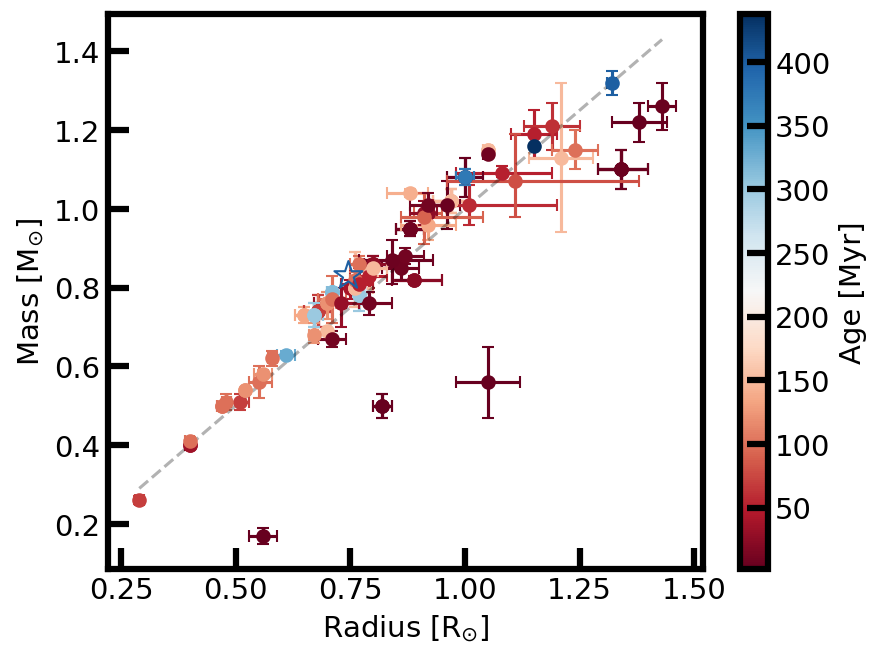

In [61]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np

x = df_hosts.st_rad
x1 = abs(df_hosts.st_raderr2)
x2 = df_hosts.st_raderr1
y = df_hosts.st_mass
y1 = abs(df_hosts.st_masserr2)
y2 = df_hosts.st_masserr1
z = df_hosts.Age_mean

# Create colormap
cmap = plt.cm.RdBu
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Start plot
fig, ax = plt.subplots()

# Plot each point and its error bar in corresponding color
for xi, yi, x1i, x2i, y1i, y2i, ci in zip(x, y, x1, x2, y1, y2, z):
    color = cmap(norm(ci))
    ax.errorbar(xi, yi, 
                xerr=[[x1i], [x2i]], 
                yerr=[[y1i], [y2i]], 
                fmt='o', color=color, ecolor=color, capsize=3)
cc = cmap(norm(400))
ax.scatter(0.746, 0.83, 
            # xerr=[0.008], 
            # yerr=[0.01], 
            marker='*', s=200, facecolors='none', edgecolor=cc, zorder=100)

xx = np.linspace(min(x),max(x),100)
ax.plot(xx, xx, ls='--', c='k', alpha=0.3)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Age [Myr]')
# plt.title("Young host stars")
plt.xlabel(r"Radius [R$_{\odot}$]")
plt.ylabel(r"Mass [M$_{\odot}$]")

Text(0.5, 0, 'Teff error [K]')

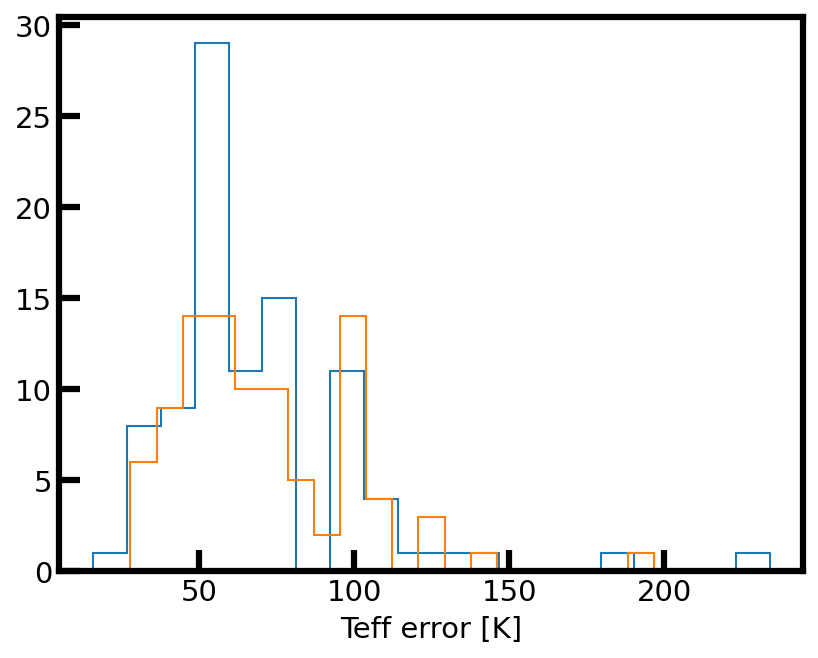

In [28]:
fig, ax = plt.subplots()

x1 = abs(df_hosts.st_tefferr2)
x2 = df_hosts.st_tefferr1
ax.hist(x1, bins=20, histtype='step');
ax.hist(x2, bins=20, histtype='step');
ax.set_xlabel('Teff error [K]')

Text(0.5, 0, '$\\log$g error [cgs]')

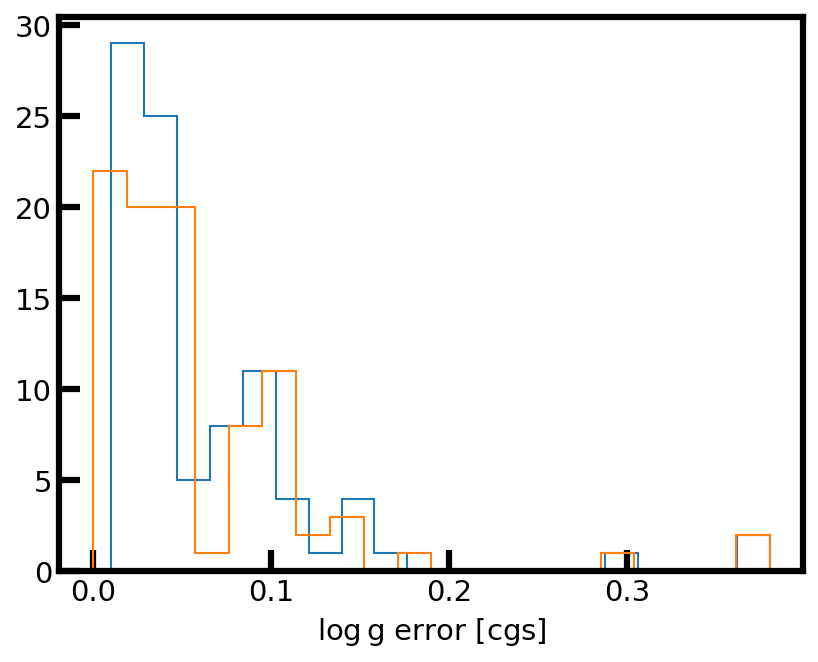

In [34]:
fig, ax = plt.subplots()

x1 = abs(df_hosts.st_loggerr2)
x2 = df_hosts.st_loggerr1
ax.hist(x1, bins=20, histtype='step');
ax.hist(x2, bins=20, histtype='step');
ax.set_xlabel(r'$\log$g error [cgs]')

Text(0.5, 0, '[Fe/H] error [dex]')

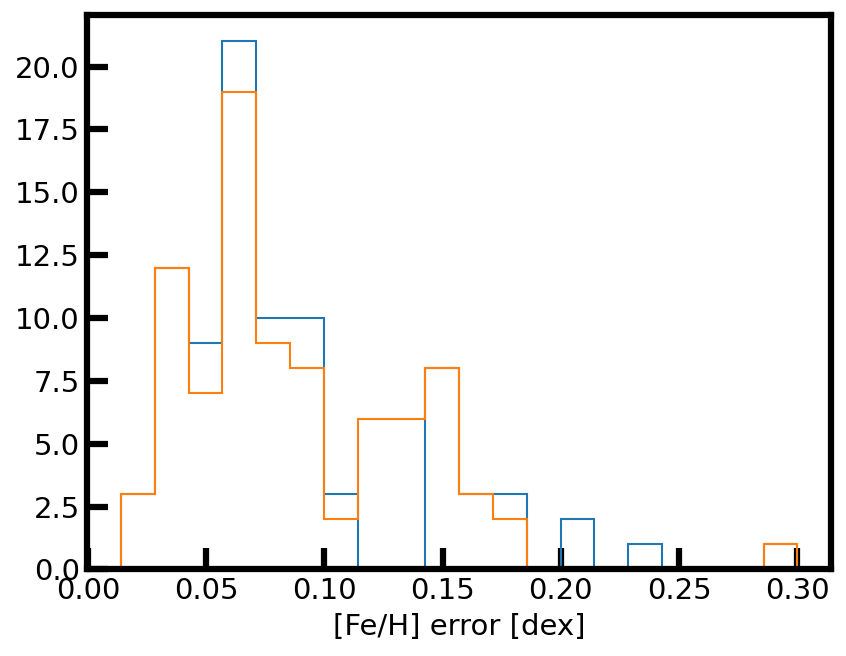

In [35]:
fig, ax = plt.subplots()

x1 = abs(df_hosts.st_meterr2)
x2 = df_hosts.st_meterr1
ax.hist(x1, bins=20, histtype='step');
ax.hist(x2, bins=20, histtype='step');
ax.set_xlabel('[Fe/H] error [dex]')